In [1]:
import os
import sys

sys.path.append("..")

import re
from collections import OrderedDict

import config
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlalchemy
from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection
from sqlalchemy import desc, func, select
from sqlalchemy.sql.expression import and_, or_

import cyclops
import cyclops.query_mimic as qm
import cyclops.query_utils as q_utils
from cyclops.orm import Database
from cyclops.processors.column_names import (
    ADMIT_TIMESTAMP,
    AGE,
    DIAGNOSIS_CODE,
    ENCOUNTER_ID,
    HOSPITAL_ID,
    LAB_TEST_NAME,
    LAB_TEST_RESULT_UNIT,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_TIMESTAMP,
    REFERENCE_RANGE,
)
from cyclops.processors.diagnosis_codes import DiagnosisProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.processors.labs import LabsProcessor
from cyclops.queries import query_gemini_delirium_diagnosis, query_gemini_delirium_lab

%load_ext autoreload
%autoreload 2 # Load when external files are updated
%load_ext nb_black

2022-04-05 13:26:43,234 INFO config          - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,266 INFO cyclops.utils.profile - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,268 INFO cyclops.query_utils - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,269 INFO cyclops.orm     - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,271 INFO cyclops.processors.base - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,272 INFO cyclops.processors.diagnosis_codes - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,274 INFO cyclops.processors.labs - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-04-05 13:26:43,294 INFO cyclops.processors.feature_handler - Log file is /home/kmckeen/gemini/cyclops/log.log


<IPython.core.display.Javascript object>

# Setup ORM

In [2]:
os.environ["USER"] = "postgres"
os.environ["PGPASSWORD"] = "pwd"
cfg = config.read_config("../configs/default/*.yaml")
db = Database(cfg)

2022-04-05 13:26:44,185 INFO cyclops.orm     - Database setup, ready to run queries!


<IPython.core.display.Javascript object>

MIMIC EDA
See sample_code/delirium.ipynb

In sample_code/data_layer.ipynb:
from evidently.dashboard.tabs import DataQualityTab

# Feature extraction

In [3]:
from cyclops.processors.column_names import DIAGNOSIS_CODE, ENCOUNTER_ID

<IPython.core.display.Javascript object>

In [4]:
query = qm.patient_diagnoses(db, version=10, include_icd_title=True)
query = qm.join_with_patients(db, query)
query = q_utils.drop_attributes(
    query,
    [
        "anchor_year",
        "dod",
        "anchor_year_group_start",
        "anchor_year_group_end",
        "year",
        "anchor_year_difference",
    ],
)
query = q_utils.rename_attributes(
    query, {"hadm_id": ENCOUNTER_ID, "icd_code": DIAGNOSIS_CODE, "anchor_age": "age"}
)

data = db.run_query(query)
data

2022-04-05 13:26:56,068 INFO cyclops.orm     - Query returned successfully!
2022-04-05 13:26:56,069 INFO cyclops.utils.profile - Finished executing function wrapper_func in 11.840656 s


,subject_id,encounter_id,seq_num,diagnosis_code,icd_version,icd_title,subject_id_1,gender,age
0,13388967,24010109,3,A0100,10,"Typhoid fever, unspecified",13388967,F,31
1,15037531,23780656,3,A0100,10,"Typhoid fever, unspecified",15037531,M,56
2,14395542,25341581,1,A0100,10,"Typhoid fever, unspecified",14395542,M,52
3,17894015,24545751,1,A020,10,Salmonella enteritis,17894015,F,53
4,10459005,27344952,1,A020,10,Salmonella enteritis,10459005,M,60
...,...,...,...,...,...,...,...,...,...
2189976,12040402,27097666,17,Z9989,10,Dependence on other enabling machines and devices,12040402,M,52
2189977,17744699,21953712,14,Z9989,10,Dependence on other enabling machines and devices,17744699,M,57
2189978,13885966,24170044,16,Z9989,10,Dependence on other enabling machines and devices,13885966,M,66
2189979,15897100,25337810,10,Z9989,10,Dependence on other enabling machines and devices,15897100,F,74


<IPython.core.display.Javascript object>

## Target

We have all data we need, so we can determine the targets. In this case, it's any code relating to delirium:

In [5]:
data["target"] = data["icd_title"].str.contains("delirium", case=False)
data.head()

,subject_id,encounter_id,seq_num,diagnosis_code,icd_version,icd_title,subject_id_1,gender,age,target
0,13388967,24010109,3,A0100,10,"Typhoid fever, unspecified",13388967,F,31,False
1,15037531,23780656,3,A0100,10,"Typhoid fever, unspecified",15037531,M,56,False
2,14395542,25341581,1,A0100,10,"Typhoid fever, unspecified",14395542,M,52,False
3,17894015,24545751,1,A020,10,Salmonella enteritis,17894015,F,53,False
4,10459005,27344952,1,A020,10,Salmonella enteritis,10459005,M,60,False


<IPython.core.display.Javascript object>

Get encounter IDs where they have the target diagnoses

In [6]:
target_encounters = data[ENCOUNTER_ID][data["target"]].drop_duplicates().to_numpy()
target_encounters

array([27531305, 22943254, 24320576, ..., 25077908, 29510882, 24504249])

<IPython.core.display.Javascript object>

Alternatively, we could have queried this data again:

In [7]:
query = qm.patient_diagnoses_by_substring(db, "delirium", version=10)
query = q_utils.rename_attributes(
    query, {"hadm_id": ENCOUNTER_ID, "icd_code": DIAGNOSIS_CODE}
)
target_df = db.run_query(query)
target_df.head()

2022-04-05 13:26:57,984 INFO cyclops.orm     - Query returned successfully!
2022-04-05 13:26:57,985 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.394947 s


,subject_id,encounter_id,seq_num,diagnosis_code,icd_version,icd_title,icd_title_1
0,13507519,24045275,14,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition
1,10304606,25532105,17,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition
2,14386462,24099024,7,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition
3,12731868,24987497,3,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition
4,15573871,20194508,13,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition


<IPython.core.display.Javascript object>

In [8]:
target_encounters2 = target_df[ENCOUNTER_ID].values
target_encounters2

array([24045275, 25532105, 24099024, ..., 23646366, 25678185, 29479252])

<IPython.core.display.Javascript object>

Aside from the order, these are identical:

In [9]:
set(target_encounters) == set(target_encounters2)

True

<IPython.core.display.Javascript object>

## Features

In [10]:
must_have_columns = [ENCOUNTER_ID, DIAGNOSIS_CODE]
data_diagnosis = data[must_have_columns]

diagnosis_processor = DiagnosisProcessor(data_diagnosis, must_have_columns)
diagnosis_features = diagnosis_processor.process()
diagnosis_features.index.names = [ENCOUNTER_ID]
diagnosis_features.head()

2022-04-05 13:26:58,142 INFO cyclops.processors.base - Processing raw diagnosis codes...
2022-04-05 13:26:58,174 INFO cyclops.processors.base - # samples: 2189981, # encounters: 185743
2022-04-05 13:27:54,903 INFO cyclops.processors.base - Converting diagnosis codes to ICD codes...
2022-04-05 13:27:54,935 INFO cyclops.processors.base - # samples: 2189981, # encounters: 185743
2022-04-05 13:27:55,067 INFO cyclops.processors.diagnosis_codes - # diagnosis features: 22, # encounters: 185743
2022-04-05 13:29:26,569 INFO cyclops.utils.profile - Finished executing function process in 148.426562 s


,A00_B99,C00_D49,E00_E89,D50_D89,F01_F99,G00_G99,H00_H59,I00_I99,H60_H95,J00_J99,...,M00_M99,N00_N99,O00_O99,P00_P96,Q00_Q99,R00_R99,S00_T88,V00_Y99,Z00_Z99,
encounter_id,,,,,,,,,,,,,,,,,,,,,
24010109,1,0,1,1,0,0,0,0,0,1,...,0,0,1,1,0,1,0,1,1,1
23780656,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
25341581,1,0,1,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
24545751,1,0,1,0,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
27344952,1,0,1,1,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0


<IPython.core.display.Javascript object>

### Patient statics features

In [11]:
# Get statics
statics = data[[ENCOUNTER_ID, "gender", "age"]]
statics.head()

,encounter_id,gender,age
0,24010109,F,31
1,23780656,M,56
2,25341581,M,52
3,24545751,F,53
4,27344952,M,60


<IPython.core.display.Javascript object>

In [12]:
# Join features with statics
diagnosis_features = pd.merge(diagnosis_features, statics, on=ENCOUNTER_ID)
diagnosis_features.set_index(ENCOUNTER_ID, inplace=True)
diagnosis_features.head()

,A00_B99,C00_D49,E00_E89,D50_D89,F01_F99,G00_G99,H00_H59,I00_I99,H60_H95,J00_J99,...,O00_O99,P00_P96,Q00_Q99,R00_R99,S00_T88,V00_Y99,Z00_Z99,,gender,age
encounter_id,,,,,,,,,,,,,,,,,,,,,
24010109,1,0,1,1,0,0,0,0,0,1,...,1,1,0,1,0,1,1,1,F,31
24010109,1,0,1,1,0,0,0,0,0,1,...,1,1,0,1,0,1,1,1,F,31
24010109,1,0,1,1,0,0,0,0,0,1,...,1,1,0,1,0,1,1,1,F,31
24010109,1,0,1,1,0,0,0,0,0,1,...,1,1,0,1,0,1,1,1,F,31
24010109,1,0,1,1,0,0,0,0,0,1,...,1,1,0,1,0,1,1,1,F,31


<IPython.core.display.Javascript object>

## Label leakage

In [13]:
# Check to make sure none of the feature code overlap with the target codes
target_codes = set(data[DIAGNOSIS_CODE][data["target"]].values)
# feature_codes = None
# assert len(target_codes.intersection(feature_codes)) == 0

<IPython.core.display.Javascript object>

## Combine features and target

In [14]:
is_target = np.in1d(diagnosis_features.index, target_encounters)
diagnosis_features["target"] = is_target.astype(int)
diagnosis_features.head()

,A00_B99,C00_D49,E00_E89,D50_D89,F01_F99,G00_G99,H00_H59,I00_I99,H60_H95,J00_J99,...,P00_P96,Q00_Q99,R00_R99,S00_T88,V00_Y99,Z00_Z99,,gender,age,target
encounter_id,,,,,,,,,,,,,,,,,,,,,
24010109,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,F,31,0
24010109,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,F,31,0
24010109,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,F,31,0
24010109,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,F,31,0
24010109,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,1,1,1,F,31,0


<IPython.core.display.Javascript object>

In [15]:
# Percentage of true targets
diagnosis_features["target"].sum() / len(diagnosis_features)

0.035719487977292956

<IPython.core.display.Javascript object>

### AGE BROKEN - FIX

NOTE: I still think some of the ages shouldn't be 0 when they are.

This age doesn't actually correspond to the hospital visit? Need to sort this out. Where is the approx year in the hospital table?

# Feature Store

## Dataset Prep

Introduction: https://docs.feast.dev/

Quickstart: https://docs.feast.dev/getting-started/quickstart

Quickstart Colab: https://colab.research.google.com/github/feast-dev/feast/blob/master/examples/quickstart/quickstart.ipynb

Feature Repository: https://docs.feast.dev/reference/feature-repository



In [16]:
%%sh
pip install wheel
pip install feast -U -q
pip install Pygments -q
echo "Please restart your runtime now (Runtime -> Restart runtime). This ensures that the correct dependencies are loaded."

Please restart your runtime now (Runtime -> Restart runtime). This ensures that the correct dependencies are loaded.


<IPython.core.display.Javascript object>

In [17]:
!feast init feature_repo


Creating a new Feast repository in /home/kmckeen/gemini/cyclops/sample_code/feature_repo.



<IPython.core.display.Javascript object>

In [18]:
%cd feature_repo
!ls -R

/home/kmckeen/gemini/cyclops/sample_code/feature_repo
.:
data  example.py  feature_store.yaml  __init__.py

./data:
driver_stats.parquet


<IPython.core.display.Javascript object>

In [19]:
!pygmentize feature_store.yaml

project: feature_repo
registry: data/registry.db
provider: local
online_store:
    path: data/online_store.db


<IPython.core.display.Javascript object>

In [20]:
import pandas as pd

pd.read_parquet("data/driver_stats.parquet")

,event_timestamp,driver_id,conv_rate,acc_rate,avg_daily_trips,created
0,2022-03-21 13:00:00+00:00,1005,0.330807,0.944868,798,2022-04-05 13:29:35.327
1,2022-03-21 14:00:00+00:00,1005,0.960575,0.104128,492,2022-04-05 13:29:35.327
2,2022-03-21 15:00:00+00:00,1005,0.970518,0.532319,796,2022-04-05 13:29:35.327
3,2022-03-21 16:00:00+00:00,1005,0.732315,0.731118,152,2022-04-05 13:29:35.327
4,2022-03-21 17:00:00+00:00,1005,0.366926,0.319067,71,2022-04-05 13:29:35.327
...,...,...,...,...,...,...
1802,2022-04-05 11:00:00+00:00,1001,0.986376,0.252727,99,2022-04-05 13:29:35.327
1803,2022-04-05 12:00:00+00:00,1001,0.509289,0.845647,25,2022-04-05 13:29:35.327
1804,2021-04-12 07:00:00+00:00,1001,0.951081,0.960201,784,2022-04-05 13:29:35.327
1805,2022-03-29 01:00:00+00:00,1003,0.745420,0.999836,100,2022-04-05 13:29:35.327


<IPython.core.display.Javascript object>

In [21]:
!pygmentize -f terminal16m example.py

# This is an example feature definition file

from google.protobuf.duration_pb2 import Duration

from feast import Entity, Feature, FeatureView, FileSource, ValueType

# Read data from parquet files. Parquet is convenient for local development mode. For
# production, you can use your favorite DWH, such as BigQuery. See Feast documentation
# for more info.
driver_hourly_stats = FileSource(
    path="/home/kmckeen/gemini/cyclops/sample_code/feature_repo/data/driver_stats.parquet",
    event_timestamp_column="event_timestamp",
    created_timestamp_column="created",
)

# Define an entity for the driver. You can think of entity as a primary key used to
# fetch features.
driver = Entity(name="driver_id", value_type=ValueType.INT64, description="driver id",)

# Our parquet files contain sample data that includes a driver_id column, timestamps and
# three feature column. Here we define a Feature View that will allow us to serve this
# data to our model online.
driver_hourly_stats_view = Featu

<IPython.core.display.Javascript object>

In [22]:
!feast apply

Created data source /home/kmckeen/gemini/cyclops/sample_code/feature_repo/data/driver_stats.parquet
Created entity driver_id
Created feature view driver_hourly_stats

Created sqlite table feature_repo_driver_hourly_stats



<IPython.core.display.Javascript object>

In [23]:
from datetime import datetime, timedelta

import pandas as pd
from feast import FeatureStore

# The entity dataframe is the dataframe we want to enrich with feature values
entity_df = pd.DataFrame.from_dict(
    {
        "driver_id": [1001, 1002, 1003],
        "label_driver_reported_satisfaction": [1, 5, 3],
        "event_timestamp": [
            datetime.now() - timedelta(minutes=11),
            datetime.now() - timedelta(minutes=36),
            datetime.now() - timedelta(minutes=73),
        ],
    }
)

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "driver_hourly_stats:conv_rate",
        "driver_hourly_stats:acc_rate",
        "driver_hourly_stats:avg_daily_trips",
    ],
).to_df()

print("----- Feature schema -----\n")
print(training_df.info())

print()
print("----- Example features -----\n")
print(training_df.head())

----- Feature schema -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 720 to 1081
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   driver_id                           3 non-null      int64              
 1   label_driver_reported_satisfaction  3 non-null      int64              
 2   event_timestamp                     3 non-null      datetime64[ns, UTC]
 3   conv_rate                           3 non-null      float32            
 4   acc_rate                            3 non-null      float32            
 5   avg_daily_trips                     3 non-null      int32              
dtypes: datetime64[ns, UTC](1), float32(2), int32(1), int64(2)
memory usage: 132.0 bytes
None

----- Example features -----

      driver_id  label_driver_reported_satisfaction  \
720        1002                                   5   
359        1001 

<IPython.core.display.Javascript object>

In [24]:
from datetime import datetime

!feast materialize-incremental {datetime.now().isoformat()}

Materializing 1 feature views to 2022-04-05 09:29:39-04:00 into the sqlite online store.

driver_hourly_stats from 2022-04-04 17:29:40-04:00 to 2022-04-05 09:29:39-04:00:
100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1044.71it/s]


<IPython.core.display.Javascript object>

In [25]:
print("--- Data directory ---")
!ls data

import sqlite3

import pandas as pd

con = sqlite3.connect("data/online_store.db")
print("\n--- Schema of online store ---")
print(
    pd.read_sql_query(
        "SELECT * FROM feature_repo_driver_hourly_stats", con
    ).columns.tolist()
)
con.close()

--- Data directory ---
driver_stats.parquet  online_store.db  registry.db

--- Schema of online store ---
['entity_key', 'feature_name', 'value', 'event_ts', 'created_ts']


<IPython.core.display.Javascript object>

In [26]:
from pprint import pprint

from feast import FeatureStore

store = FeatureStore(repo_path=".")

feature_vector = store.get_online_features(
    features=[
        "driver_hourly_stats:conv_rate",
        "driver_hourly_stats:acc_rate",
        "driver_hourly_stats:avg_daily_trips",
    ],
    entity_rows=[
        {"driver_id": 1004},
        {"driver_id": 1005},
    ],
).to_dict()

pprint(feature_vector)

{'acc_rate': [0.8855195641517639, 0.6322959065437317],
 'avg_daily_trips': [903, 501],
 'conv_rate': [0.975480318069458, 0.8715831637382507],
 'driver_id': [1004, 1005]}


<IPython.core.display.Javascript object>

# H20 Baseline Handler

In [27]:
!pip install h2o

<IPython.core.display.Javascript object>

In [28]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpau_wpd0d
  JVM stdout: /tmp/tmpau_wpd0d/h2o_postgres_started_from_python.out
  JVM stderr: /tmp/tmpau_wpd0d/h2o_postgres_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_postgres_ftljii
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.830 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


<IPython.core.display.Javascript object>

In [29]:
# EMPTY STRING COLUMN CAUSING ISSUES?
diagnosis_features = diagnosis_features.drop([""], axis=1)

<IPython.core.display.Javascript object>

In [30]:
frame = h2o.H2OFrame(diagnosis_features)

# Convert variables to categorical
# asfactor(): Convert column/columns in the current frame to categoricals.
for c in frame.columns:
    # All columns are categorical (diagnoses/gender), except for age
    if c != "age":
        frame[c] = frame[c].asfactor()

training_frame, validation_frame = frame.split_frame(ratios=[0.8], seed=1234)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


<IPython.core.display.Javascript object>

In [31]:
len(training_frame)

1751984

<IPython.core.display.Javascript object>

In [32]:
len(validation_frame)

437997

<IPython.core.display.Javascript object>

In [33]:
y = "target"
x = [i for i in list(diagnosis_features.columns) if i != y]

<IPython.core.display.Javascript object>

In [34]:
# AN ASIDE: Is this of any use to us, perhaps in the feature handler?
"""
# Automatic label preprocessing?
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
train_x = train_x.apply(
    lambda col: label.fit_transform(col), axis=0, result_type="expand"
)
test_x = test_x.apply(
    lambda col: label.fit_transform(col), axis=0, result_type="expand"
)
train_x
"""

'\n# Automatic label preprocessing?\nfrom sklearn.preprocessing import LabelEncoder\n\nlabel = LabelEncoder()\ntrain_x = train_x.apply(\n    lambda col: label.fit_transform(col), axis=0, result_type="expand"\n)\ntest_x = test_x.apply(\n    lambda col: label.fit_transform(col), axis=0, result_type="expand"\n)\ntrain_x\n'

<IPython.core.display.Javascript object>

In [35]:
automl = H2OAutoML(max_models=30, max_runtime_secs=300, seed=1, balance_classes=True)
automl.train(x=x, y=y, training_frame=training_frame, validation_frame=validation_frame)
leader = automl.leaderboard
leader.head()

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20220405_133009,0.999446,0.0110575,0.985995,0.0363028,0.0604532,0.00365459
StackedEnsemble_BestOfFamily_2_AutoML_1_20220405_133009,0.999446,0.0259799,0.985994,0.0354953,0.0765045,0.00585294
StackedEnsemble_AllModels_1_AutoML_1_20220405_133009,0.999446,0.036471,0.985995,0.0357692,0.092374,0.00853295
XGBoost_1_AutoML_1_20220405_133009,0.999446,0.0293617,0.985991,0.0356795,0.0872773,0.00761732
GBM_1_AutoML_1_20220405_133009,0.998996,0.0301147,0.97332,0.0289463,0.0993163,0.00986373
DRF_1_AutoML_1_20220405_133009,0.980306,0.0728683,0.667085,0.170578,0.15159,0.0229796
XGBoost_2_AutoML_1_20220405_133009,0.965857,0.270414,0.523585,0.202327,0.305143,0.0931123
GBM_4_AutoML_1_20220405_133009,0.92815,0.130301,0.302813,0.303668,0.182074,0.0331511
GBM_3_AutoML_1_20220405_133009,0.9123,0.128857,0.253145,0.303793,0.181723,0.0330232
GBM_2_AutoML_1_20220405_133009,0.908262,0.132427,0.250628,0.311117,0.182432,0.0332813


<IPython.core.display.Javascript object>

In [36]:
leader.head(rows=leader.nrows)  # Entire leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20220405_133009,0.999446,0.0110575,0.985995,0.0363028,0.0604532,0.00365459
StackedEnsemble_BestOfFamily_2_AutoML_1_20220405_133009,0.999446,0.0259799,0.985994,0.0354953,0.0765045,0.00585294
StackedEnsemble_AllModels_1_AutoML_1_20220405_133009,0.999446,0.036471,0.985995,0.0357692,0.092374,0.00853295
XGBoost_1_AutoML_1_20220405_133009,0.999446,0.0293617,0.985991,0.0356795,0.0872773,0.00761732
GBM_1_AutoML_1_20220405_133009,0.998996,0.0301147,0.97332,0.0289463,0.0993163,0.00986373
DRF_1_AutoML_1_20220405_133009,0.980306,0.0728683,0.667085,0.170578,0.15159,0.0229796
XGBoost_2_AutoML_1_20220405_133009,0.965857,0.270414,0.523585,0.202327,0.305143,0.0931123
GBM_4_AutoML_1_20220405_133009,0.92815,0.130301,0.302813,0.303668,0.182074,0.0331511
GBM_3_AutoML_1_20220405_133009,0.9123,0.128857,0.253145,0.303793,0.181723,0.0330232
GBM_2_AutoML_1_20220405_133009,0.908262,0.132427,0.250628,0.311117,0.182432,0.0332813


<IPython.core.display.Javascript object>

In [37]:
automl.leader.params.keys()

dict_keys(['model_id', 'training_frame', 'response_column', 'validation_frame', 'blending_frame', 'base_models', 'metalearner_algorithm', 'metalearner_nfolds', 'metalearner_fold_assignment', 'metalearner_fold_column', 'metalearner_params', 'metalearner_transform', 'max_runtime_secs', 'weights_column', 'offset_column', 'seed', 'score_training_samples', 'keep_levelone_frame', 'export_checkpoints_dir', 'auc_type'])

<IPython.core.display.Javascript object>

In [38]:
m = h2o.get_model(automl.leader)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_1_20220405_133009

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0030952593798903687
RMSE: 0.055635055314885495
LogLoss: 0.009536865360857539
Null degrees of freedom: 10043
Residual degrees of freedom: 10042
Null deviance: 3017.7429298921015
Residual deviance: 191.576551368906
AIC: 195.576551368906
AUC: 0.9995866097212394
AUCPR: 0.9890626282781934
Gini: 0.9991732194424787

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6371987870681579: 


,,0,1,Error,Rate
0,0,9683.0,14.0,0.0014,(14.0/9697.0)
1,1,29.0,318.0,0.0836,(29.0/347.0)
2,Total,9712.0,332.0,0.0043,(43.0/10044.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,6.371988e-01,0.936672,257.0
1,max f2,2.190397e-01,0.961003,325.0
2,max f0point5,7.227874e-01,0.963361,235.0
3,max accuracy,6.371988e-01,0.995719,257.0
4,max precision,9.998961e-01,1.000000,0.0
5,max recall,3.311986e-02,1.000000,339.0
6,max specificity,9.998961e-01,1.000000,0.0
7,max absolute_mcc,6.371988e-01,0.934702,257.0
8,max min_per_class_accuracy,2.190397e-01,0.993606,325.0
9,max mean_per_class_accuracy,3.311986e-02,0.996030,339.0



Gains/Lift Table: Avg response rate:  3.45 %, avg score:  3.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010155,9.923272e-01,28.945245,28.945245,1.000000,9.965794e-01,1.000000,0.996579,0.293948,0.293948,2794.524496,2794.524496,0.293948
1,2,0.020012,9.774732e-01,28.945245,28.945245,1.000000,9.865259e-01,1.000000,0.991628,0.285303,0.579251,2794.524496,2794.524496,0.579251
2,3,0.030167,7.533141e-01,27.810137,28.563130,0.960784,9.204779e-01,0.986799,0.967676,0.282421,0.861671,2681.013731,2756.312951,0.861259
3,4,0.040024,2.563946e-01,12.572177,24.625059,0.434343,5.244369e-01,0.850746,0.858520,0.123919,0.985591,1157.217710,2362.505914,0.979403
4,5,0.050080,2.619015e-04,1.432933,19.968191,0.049505,3.333334e-02,0.689861,0.692827,0.014409,1.000000,43.293292,1896.819085,0.983913
5,6,0.100060,1.132156e-05,0.000000,9.994030,0.000000,5.821569e-05,0.345274,0.346787,0.000000,1.000000,-100.000000,899.402985,0.932144
6,7,0.150040,1.474746e-06,0.000000,6.664897,0.000000,4.809775e-06,0.230259,0.231270,0.000000,1.000000,-100.000000,566.489715,0.880375
7,8,0.200020,2.791497e-07,0.000000,4.999502,0.000000,7.047530e-07,0.172723,0.173481,0.000000,1.000000,-100.000000,399.950224,0.828607
8,9,0.299980,1.127710e-08,0.000000,3.333555,0.000000,8.009776e-08,0.115168,0.115673,0.000000,1.000000,-100.000000,233.355460,0.725070
9,10,0.400040,5.917686e-10,0.000000,2.499751,0.000000,3.581901e-09,0.086361,0.086741,0.000000,1.000000,-100.000000,149.975112,0.621429




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.00365458656043989
RMSE: 0.06045317659511276
LogLoss: 0.011057481348690574
Null degrees of freedom: 437996
Residual degrees of freedom: 437995
Null deviance: 136530.1671202628
Residual deviance: 9686.287316564796
AIC: 9690.287316564796
AUC: 0.9994463257131602
AUCPR: 0.9859948375982418
Gini: 0.9988926514263203

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5250255675038205: 


,,0,1,Error,Rate
0,0,420685.0,1433.0,0.0034,(1433.0/422118.0)
1,1,1099.0,14780.0,0.0692,(1099.0/15879.0)
2,Total,421784.0,16213.0,0.0058,(2532.0/437997.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,5.250256e-01,0.921102,242.0
1,max f2,7.426772e-02,0.958455,366.0
2,max f0point5,8.209742e-01,0.952086,132.0
3,max accuracy,5.773654e-01,0.994240,223.0
4,max precision,9.998806e-01,1.000000,0.0
5,max recall,1.923409e-03,1.000000,391.0
6,max specificity,9.998806e-01,1.000000,0.0
7,max absolute_mcc,3.748870e-01,0.918220,288.0
8,max min_per_class_accuracy,1.443881e-01,0.992850,352.0
9,max mean_per_class_accuracy,9.246921e-03,0.995619,385.0



Gains/Lift Table: Avg response rate:  3.63 %, avg score:  3.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,9.927497e-01,27.583412,27.583412,1.000000,9.968448e-01,1.000000,0.996845,0.275962,0.275962,2658.341205,2658.341205,0.275962
1,2,0.020000,9.749228e-01,27.583412,27.583412,1.000000,9.851821e-01,1.000000,0.991016,0.275710,0.551672,2658.341205,2658.341205,0.551672
2,3,0.030000,8.338956e-01,26.852892,27.339906,0.973516,9.359100e-01,0.991172,0.972647,0.268531,0.820203,2585.289247,2633.990552,0.819928
3,4,0.040016,3.459123e-01,14.631092,24.158895,0.530431,6.044620e-01,0.875849,0.880491,0.146546,0.966749,1363.109183,2315.889533,0.961594
4,5,0.050007,4.197323e-04,3.328163,19.997124,0.120658,8.237967e-02,0.724969,0.721036,0.033251,1.000000,232.816306,1899.712368,0.985729
5,6,0.100005,1.455897e-05,0.000000,9.999475,0.000000,8.463747e-05,0.362518,0.360593,0.000000,1.000000,-100.000000,899.947491,0.933850
6,7,0.150006,1.862670e-06,0.000000,6.666418,0.000000,6.053968e-06,0.241682,0.240401,0.000000,1.000000,-100.000000,566.641807,0.881969
7,8,0.200001,3.161458e-07,0.000000,4.999966,0.000000,8.523133e-07,0.181267,0.180307,0.000000,1.000000,-100.000000,399.996575,0.830093
8,9,0.300016,1.281218e-08,0.000000,3.333158,0.000000,9.366019e-08,0.120839,0.120199,0.000000,1.000000,-100.000000,233.315830,0.726316
9,10,0.400003,6.271381e-10,0.000000,2.499983,0.000000,3.909692e-09,0.090634,0.090153,0.000000,1.000000,-100.000000,149.998288,0.622568



Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_1_20220405_133009

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0030952593798903687
RMSE: 0.055635055314885495
LogLoss: 0.009536865360857539
Null degrees of freedom: 10043
Residual degrees of freedom: 10042
Null deviance: 3017.7429298921015
Residual deviance: 191.576551368906
AIC: 195.576551368906
AUC: 0.9995866097212394
AUCPR: 0.9890626282781934
Gini: 0.9991732194424787

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6371987870681579: 


,,0,1,Error,Rate
0,0,9683.0,14.0,0.0014,(14.0/9697.0)
1,1,29.0,318.0,0.0836,(29.0/347.0)
2,Total,9712.0,332.0,0.0043,(43.0/10044.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,6.371988e-01,0.936672,257.0
1,max f2,2.190397e-01,0.961003,325.0
2,max f0point5,7.227874e-01,0.963361,235.0
3,max accuracy,6.371988e-01,0.995719,257.0
4,max precision,9.998961e-01,1.000000,0.0
5,max recall,3.311986e-02,1.000000,339.0
6,max specificity,9.998961e-01,1.000000,0.0
7,max absolute_mcc,6.371988e-01,0.934702,257.0
8,max min_per_class_accuracy,2.190397e-01,0.993606,325.0
9,max mean_per_class_accuracy,3.311986e-02,0.996030,339.0



Gains/Lift Table: Avg response rate:  3.45 %, avg score:  3.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010155,9.923272e-01,28.945245,28.945245,1.000000,9.965794e-01,1.000000,0.996579,0.293948,0.293948,2794.524496,2794.524496,0.293948
1,2,0.020012,9.774732e-01,28.945245,28.945245,1.000000,9.865259e-01,1.000000,0.991628,0.285303,0.579251,2794.524496,2794.524496,0.579251
2,3,0.030167,7.533141e-01,27.810137,28.563130,0.960784,9.204779e-01,0.986799,0.967676,0.282421,0.861671,2681.013731,2756.312951,0.861259
3,4,0.040024,2.563946e-01,12.572177,24.625059,0.434343,5.244369e-01,0.850746,0.858520,0.123919,0.985591,1157.217710,2362.505914,0.979403
4,5,0.050080,2.619015e-04,1.432933,19.968191,0.049505,3.333334e-02,0.689861,0.692827,0.014409,1.000000,43.293292,1896.819085,0.983913
5,6,0.100060,1.132156e-05,0.000000,9.994030,0.000000,5.821569e-05,0.345274,0.346787,0.000000,1.000000,-100.000000,899.402985,0.932144
6,7,0.150040,1.474746e-06,0.000000,6.664897,0.000000,4.809775e-06,0.230259,0.231270,0.000000,1.000000,-100.000000,566.489715,0.880375
7,8,0.200020,2.791497e-07,0.000000,4.999502,0.000000,7.047530e-07,0.172723,0.173481,0.000000,1.000000,-100.000000,399.950224,0.828607
8,9,0.299980,1.127710e-08,0.000000,3.333555,0.000000,8.009776e-08,0.115168,0.115673,0.000000,1.000000,-100.000000,233.355460,0.725070
9,10,0.400040,5.917686e-10,0.000000,2.499751,0.000000,3.581901e-09,0.086361,0.086741,0.000000,1.000000,-100.000000,149.975112,0.621429




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.00365458656043989
RMSE: 0.06045317659511276
LogLoss: 0.011057481348690574
Null degrees of freedom: 437996
Residual degrees of freedom: 437995
Null deviance: 136530.1671202628
Residual deviance: 9686.287316564796
AIC: 9690.287316564796
AUC: 0.9994463257131602
AUCPR: 0.9859948375982418
Gini: 0.9988926514263203

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5250255675038205: 


,,0,1,Error,Rate
0,0,420685.0,1433.0,0.0034,(1433.0/422118.0)
1,1,1099.0,14780.0,0.0692,(1099.0/15879.0)
2,Total,421784.0,16213.0,0.0058,(2532.0/437997.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,5.250256e-01,0.921102,242.0
1,max f2,7.426772e-02,0.958455,366.0
2,max f0point5,8.209742e-01,0.952086,132.0
3,max accuracy,5.773654e-01,0.994240,223.0
4,max precision,9.998806e-01,1.000000,0.0
5,max recall,1.923409e-03,1.000000,391.0
6,max specificity,9.998806e-01,1.000000,0.0
7,max absolute_mcc,3.748870e-01,0.918220,288.0
8,max min_per_class_accuracy,1.443881e-01,0.992850,352.0
9,max mean_per_class_accuracy,9.246921e-03,0.995619,385.0



Gains/Lift Table: Avg response rate:  3.63 %, avg score:  3.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,9.927497e-01,27.583412,27.583412,1.000000,9.968448e-01,1.000000,0.996845,0.275962,0.275962,2658.341205,2658.341205,0.275962
1,2,0.020000,9.749228e-01,27.583412,27.583412,1.000000,9.851821e-01,1.000000,0.991016,0.275710,0.551672,2658.341205,2658.341205,0.551672
2,3,0.030000,8.338956e-01,26.852892,27.339906,0.973516,9.359100e-01,0.991172,0.972647,0.268531,0.820203,2585.289247,2633.990552,0.819928
3,4,0.040016,3.459123e-01,14.631092,24.158895,0.530431,6.044620e-01,0.875849,0.880491,0.146546,0.966749,1363.109183,2315.889533,0.961594
4,5,0.050007,4.197323e-04,3.328163,19.997124,0.120658,8.237967e-02,0.724969,0.721036,0.033251,1.000000,232.816306,1899.712368,0.985729
5,6,0.100005,1.455897e-05,0.000000,9.999475,0.000000,8.463747e-05,0.362518,0.360593,0.000000,1.000000,-100.000000,899.947491,0.933850
6,7,0.150006,1.862670e-06,0.000000,6.666418,0.000000,6.053968e-06,0.241682,0.240401,0.000000,1.000000,-100.000000,566.641807,0.881969
7,8,0.200001,3.161458e-07,0.000000,4.999966,0.000000,8.523133e-07,0.181267,0.180307,0.000000,1.000000,-100.000000,399.996575,0.830093
8,9,0.300016,1.281218e-08,0.000000,3.333158,0.000000,9.366019e-08,0.120839,0.120199,0.000000,1.000000,-100.000000,233.315830,0.726316
9,10,0.400003,6.271381e-10,0.000000,2.499983,0.000000,3.909692e-09,0.090634,0.090153,0.000000,1.000000,-100.000000,149.998288,0.622568


H2OTypeError: Argument `model_id` should be a string, got H2OStackedEnsembleEstimator 

<IPython.core.display.Javascript object>

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_1_20220405_133009

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0030952593798903687
RMSE: 0.055635055314885495
LogLoss: 0.009536865360857539
Null degrees of freedom: 10043
Residual degrees of freedom: 10042
Null deviance: 3017.7429298921015
Residual deviance: 191.576551368906
AIC: 195.576551368906
AUC: 0.9995866097212394
AUCPR: 0.9890626282781934
Gini: 0.9991732194424787

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6371987870681579: 


,,0,1,Error,Rate
0,0,9683.0,14.0,0.0014,(14.0/9697.0)
1,1,29.0,318.0,0.0836,(29.0/347.0)
2,Total,9712.0,332.0,0.0043,(43.0/10044.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,6.371988e-01,0.936672,257.0
1,max f2,2.190397e-01,0.961003,325.0
2,max f0point5,7.227874e-01,0.963361,235.0
3,max accuracy,6.371988e-01,0.995719,257.0
4,max precision,9.998961e-01,1.000000,0.0
5,max recall,3.311986e-02,1.000000,339.0
6,max specificity,9.998961e-01,1.000000,0.0
7,max absolute_mcc,6.371988e-01,0.934702,257.0
8,max min_per_class_accuracy,2.190397e-01,0.993606,325.0
9,max mean_per_class_accuracy,3.311986e-02,0.996030,339.0



Gains/Lift Table: Avg response rate:  3.45 %, avg score:  3.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010155,9.923272e-01,28.945245,28.945245,1.000000,9.965794e-01,1.000000,0.996579,0.293948,0.293948,2794.524496,2794.524496,0.293948
1,2,0.020012,9.774732e-01,28.945245,28.945245,1.000000,9.865259e-01,1.000000,0.991628,0.285303,0.579251,2794.524496,2794.524496,0.579251
2,3,0.030167,7.533141e-01,27.810137,28.563130,0.960784,9.204779e-01,0.986799,0.967676,0.282421,0.861671,2681.013731,2756.312951,0.861259
3,4,0.040024,2.563946e-01,12.572177,24.625059,0.434343,5.244369e-01,0.850746,0.858520,0.123919,0.985591,1157.217710,2362.505914,0.979403
4,5,0.050080,2.619015e-04,1.432933,19.968191,0.049505,3.333334e-02,0.689861,0.692827,0.014409,1.000000,43.293292,1896.819085,0.983913
5,6,0.100060,1.132156e-05,0.000000,9.994030,0.000000,5.821569e-05,0.345274,0.346787,0.000000,1.000000,-100.000000,899.402985,0.932144
6,7,0.150040,1.474746e-06,0.000000,6.664897,0.000000,4.809775e-06,0.230259,0.231270,0.000000,1.000000,-100.000000,566.489715,0.880375
7,8,0.200020,2.791497e-07,0.000000,4.999502,0.000000,7.047530e-07,0.172723,0.173481,0.000000,1.000000,-100.000000,399.950224,0.828607
8,9,0.299980,1.127710e-08,0.000000,3.333555,0.000000,8.009776e-08,0.115168,0.115673,0.000000,1.000000,-100.000000,233.355460,0.725070
9,10,0.400040,5.917686e-10,0.000000,2.499751,0.000000,3.581901e-09,0.086361,0.086741,0.000000,1.000000,-100.000000,149.975112,0.621429




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.00365458656043989
RMSE: 0.06045317659511276
LogLoss: 0.011057481348690574
Null degrees of freedom: 437996
Residual degrees of freedom: 437995
Null deviance: 136530.1671202628
Residual deviance: 9686.287316564796
AIC: 9690.287316564796
AUC: 0.9994463257131602
AUCPR: 0.9859948375982418
Gini: 0.9988926514263203

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5250255675038205: 


,,0,1,Error,Rate
0,0,420685.0,1433.0,0.0034,(1433.0/422118.0)
1,1,1099.0,14780.0,0.0692,(1099.0/15879.0)
2,Total,421784.0,16213.0,0.0058,(2532.0/437997.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,5.250256e-01,0.921102,242.0
1,max f2,7.426772e-02,0.958455,366.0
2,max f0point5,8.209742e-01,0.952086,132.0
3,max accuracy,5.773654e-01,0.994240,223.0
4,max precision,9.998806e-01,1.000000,0.0
5,max recall,1.923409e-03,1.000000,391.0
6,max specificity,9.998806e-01,1.000000,0.0
7,max absolute_mcc,3.748870e-01,0.918220,288.0
8,max min_per_class_accuracy,1.443881e-01,0.992850,352.0
9,max mean_per_class_accuracy,9.246921e-03,0.995619,385.0



Gains/Lift Table: Avg response rate:  3.63 %, avg score:  3.61 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,9.927497e-01,27.583412,27.583412,1.000000,9.968448e-01,1.000000,0.996845,0.275962,0.275962,2658.341205,2658.341205,0.275962
1,2,0.020000,9.749228e-01,27.583412,27.583412,1.000000,9.851821e-01,1.000000,0.991016,0.275710,0.551672,2658.341205,2658.341205,0.551672
2,3,0.030000,8.338956e-01,26.852892,27.339906,0.973516,9.359100e-01,0.991172,0.972647,0.268531,0.820203,2585.289247,2633.990552,0.819928
3,4,0.040016,3.459123e-01,14.631092,24.158895,0.530431,6.044620e-01,0.875849,0.880491,0.146546,0.966749,1363.109183,2315.889533,0.961594
4,5,0.050007,4.197323e-04,3.328163,19.997124,0.120658,8.237967e-02,0.724969,0.721036,0.033251,1.000000,232.816306,1899.712368,0.985729
5,6,0.100005,1.455897e-05,0.000000,9.999475,0.000000,8.463747e-05,0.362518,0.360593,0.000000,1.000000,-100.000000,899.947491,0.933850
6,7,0.150006,1.862670e-06,0.000000,6.666418,0.000000,6.053968e-06,0.241682,0.240401,0.000000,1.000000,-100.000000,566.641807,0.881969
7,8,0.200001,3.161458e-07,0.000000,4.999966,0.000000,8.523133e-07,0.181267,0.180307,0.000000,1.000000,-100.000000,399.996575,0.830093
8,9,0.300016,1.281218e-08,0.000000,3.333158,0.000000,9.366019e-08,0.120839,0.120199,0.000000,1.000000,-100.000000,233.315830,0.726316
9,10,0.400003,6.271381e-10,0.000000,2.499983,0.000000,3.909692e-09,0.090634,0.090153,0.000000,1.000000,-100.000000,149.998288,0.622568


In [39]:
pred = automl.leader.predict(validation_frame)
pred_df = pred.as_data_frame(use_pandas=True)
pred_df.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,9.49124e-14
0,1,7.67169e-10
0,1,1.97525e-08


<IPython.core.display.Javascript object>

In [41]:
true_arr = validation_frame["target"].as_data_frame(use_pandas=True).values[:, 0]
true_arr

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [42]:
pred_arr = pred_df["predict"].values
pred_arr

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [43]:
(pred_arr == true_arr).sum() / len(validation_frame)

0.994205439763286

<IPython.core.display.Javascript object>

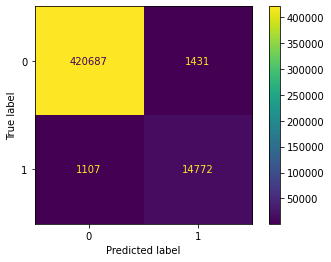

<IPython.core.display.Javascript object>

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(true_arr, pred_arr)
cmd = ConfusionMatrixDisplay(cm)
cmd.from_predictions(true_arr, pred_arr)